In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
import numpy as np
from os.path import dirname, join as pjoin
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import torch

from func2graph import data, baselines, tools

In [7]:
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
})

In [4]:
GT_strength_connectivity = np.load('../../data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')

abs_max = np.max(np.abs(GT_strength_connectivity))
vmin_KK = -abs_max
vmax_KK = abs_max

no normalization
activity shape:  (527, 3943)
neuron_ttypes shape:  527
neuron_types_result:  ['EC', 'EC', 'EC', 'EC', 'EC', 'Lamp5', 'EC', 'EC', 'EC', 'EC']
cell_type_count:  {'EC': 264, 'Lamp5': 59, 'IN': 98, 'Vip': 49, 'Sst': 13, 'Sncg': 5, 'Pvalb': 38, 'Serpinf1': 1}


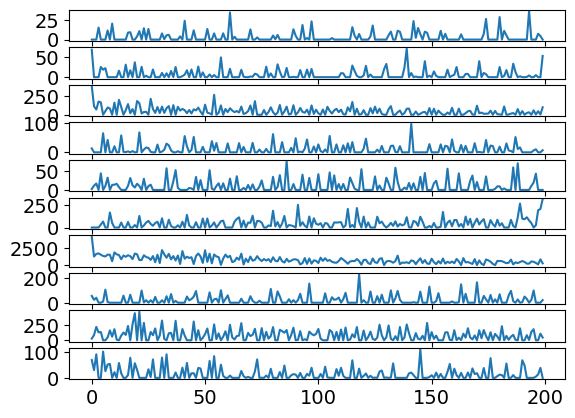

mu:  133.19855
std:  200.35959
original UniqueID:  [ nan  nan  nan  nan  nan 146.  nan  nan  nan  nan]
min remove nan:  34.0
max remove nan:  434.0
num non-nan neurons:  165
original cell type:  ['EC' 'EC' 'EC' 'EC' 'EC' 'Lamp5' 'EC' 'EC' 'EC' 'EC']
unique_neurons_in_cell_type:  {'EC': 264, 'Lamp5': 59, 'IN': 98, 'Vip': 49, 'Sst': 13, 'Sncg': 5, 'Pvalb': 38, 'Serpinf1': 1}
seen neurons:  [nan, nan, nan, nan, nan, 146.0, nan, nan, nan, nan]
len seen_neurons:  527
num unique neurons:  527
cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Serpinf1', 'Sncg', 'Sst', 'Vip']
all_sessions_new_cell_type_id:  [0 0 0 0 0 2 0 0 0 0]


In [5]:
directory = '../../data/Mouse/Bugeon/'

input_sessions_file_path = [
    # {'date_exp': 'SB025/2019-10-04/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB025/2019-10-07/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB025/2019-10-08/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB025/2019-10-09/', 'input_setting': 'Blank/01/'},
    {'date_exp': 'SB025/2019-10-23/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB025/2019-10-24/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB026/2019-10-11/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB026/2019-10-14/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB026/2019-10-16/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-06/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-07/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-08/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-12/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB028/2019-11-13/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB030/2020-01-08/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB030/2020-01-10/', 'input_setting': 'Blank/01/'},
    # {'date_exp': 'SB030/2020-01-28/', 'input_setting': 'Blank/01/'},
]

normalization = "no"    #####################################

all_sessions_original_UniqueID = []
all_sessions_original_cell_type = []
all_sessions_acitvity = []
num_neurons_per_session = []

sessions_2_original_cell_type = []

all_sessions_activity_flatten = []

for i in range(len(input_sessions_file_path)):
    date_exp = input_sessions_file_path[i]['date_exp']
    input_setting = input_sessions_file_path[i]['input_setting']

    activity, frame_times, UniqueID, neuron_ttypes = data.load_mouse_data_session(
        directory, date_exp, input_setting, normalization
    )

    print('activity shape: ', activity.shape) 
    print('neuron_ttypes shape: ', len(neuron_ttypes))

    all_sessions_original_UniqueID.append(UniqueID)
    all_sessions_acitvity.append(activity)
    num_neurons_per_session.append(activity.shape[0])

    all_sessions_activity_flatten.append(activity.flatten())

    # Get the first level of cell types
    neuron_types_result = []
    for j in range(len(neuron_ttypes)):
        # split by "-"
        neuron_types_result.append(neuron_ttypes[j].split("-")[0])

    sessions_2_original_cell_type.append(neuron_types_result)
    all_sessions_original_cell_type.append(neuron_types_result)
    print('neuron_types_result: ', neuron_types_result[:10])

    # Compute the number of neurons per cell type
    cell_type_count = {}
    for cell_type in neuron_types_result:
        if cell_type in cell_type_count:
            cell_type_count[cell_type] += 1
        else:
            cell_type_count[cell_type] = 1
    print('cell_type_count: ', cell_type_count)

    # plot activity
    for i in range(10):
        plt.subplot(10, 1, i+1)
        plt.plot(activity[i,:][:200])
    plt.show()


# Flatten the list
all_sessions_original_UniqueID_flatten = np.concatenate(all_sessions_original_UniqueID)
all_sessions_original_cell_type_flatten = np.concatenate(all_sessions_original_cell_type)


# Normalize the activity
all_sessions_activity_flatten = np.concatenate(all_sessions_activity_flatten)
mu = np.mean(all_sessions_activity_flatten)
std = np.std(all_sessions_activity_flatten)
print('mu: ', mu)
print('std: ', std)

all_sessions_acitvity = [(session - mu) / std for session in all_sessions_acitvity]

print('original UniqueID: ', all_sessions_original_UniqueID_flatten[:10])
remove_nan = all_sessions_original_UniqueID_flatten[~np.isnan(all_sessions_original_UniqueID_flatten)]
print('min remove nan: ', np.min(remove_nan))
print('max remove nan: ', np.max(remove_nan))
print('num non-nan neurons: ', len(remove_nan))
print('original cell type: ', all_sessions_original_cell_type_flatten[:10])




# calculate unique neurons in each cell type
unique_neurons_in_cell_type = {}
seen_neurons = []
for i in range(len(all_sessions_original_cell_type_flatten)):
    cell_type = all_sessions_original_cell_type_flatten[i]
    neuron_id = all_sessions_original_UniqueID_flatten[i]

    if ~np.isnan(neuron_id):
        if (neuron_id in seen_neurons):
            continue

    seen_neurons.append(neuron_id)
    if cell_type in unique_neurons_in_cell_type:
        unique_neurons_in_cell_type[cell_type] += 1
    else:
        unique_neurons_in_cell_type[cell_type] = 1

print('unique_neurons_in_cell_type: ', unique_neurons_in_cell_type)
print('seen neurons: ', seen_neurons[:10])
print('len seen_neurons: ', len(seen_neurons))


##############################################
# Construct new neuron id
##############################################
all_sessions_new_UniqueID, num_unqiue_neurons = tools.assign_unique_neuron_ids(all_sessions_original_UniqueID_flatten, num_neurons_per_session)
print('num unique neurons: ', num_unqiue_neurons)

##############################################
# Construct new cell type id
##############################################
all_sessions_new_cell_type_id, cell_type_order = tools.assign_unique_cell_type_ids(all_sessions_original_cell_type_flatten, num_neurons_per_session)
print('all_sessions_new_cell_type_id: ', all_sessions_new_cell_type_id[0][:10]) # a list of sessions new cell type, each session is a 1D array of shape num_neurons

max in activity:  23.490005
min in activity:  -0.6647975
mean in activity:  -2.5366194e-07
std in activity:  0.99999994
count how many values below 0:  1406415
count how many values equal 0:  0


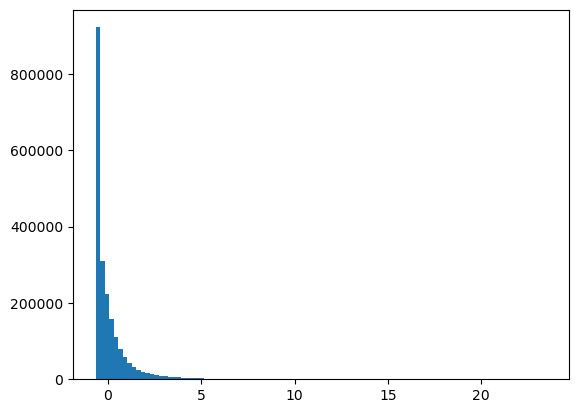

max in all_activity:  23.490005
min in all_activity:  -0.6647975
mean in all_activity:  -2.5366194e-07
std in all_activity:  0.99999994
count how many values below 0:  1406415
count how many values equal 0:  0


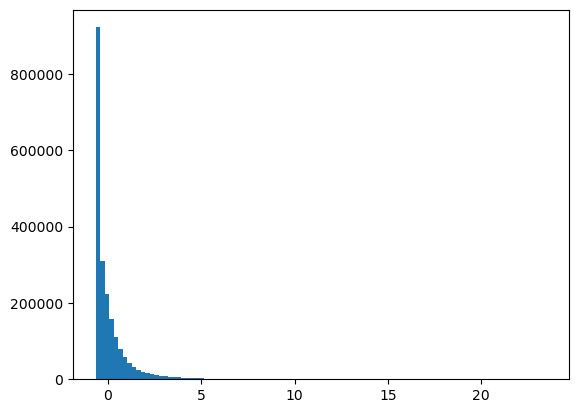

In [6]:
# One session activity
activity = all_sessions_acitvity[0]

print('max in activity: ', np.max(activity))
print('min in activity: ', np.min(activity))
print('mean in activity: ', np.mean(activity))
print('std in activity: ', np.std(activity))

print('count how many values below 0: ', np.sum(activity<0))
print('count how many values equal 0: ', np.sum(activity==0))

# plot distribution of activity
plt.hist(activity.flatten(), bins=100)
plt.show()

# flatten ALL activity
all_activity = []
for i in range(len(all_sessions_acitvity)):
    all_activity.append(all_sessions_acitvity[i].flatten())
all_activity = np.concatenate(all_activity)

print('max in all_activity: ', np.max(all_activity))
print('min in all_activity: ', np.min(all_activity))
print('mean in all_activity: ', np.mean(all_activity))
print('std in all_activity: ', np.std(all_activity))

print('count how many values below 0: ', np.sum(all_activity<0))
print('count how many values equal 0: ', np.sum(all_activity==0))

plt.hist(all_activity, bins=100)
plt.show()

### Explore different time steps in the same session

session0 shape:  (522, 5248)
corr:  0.020067318095590835


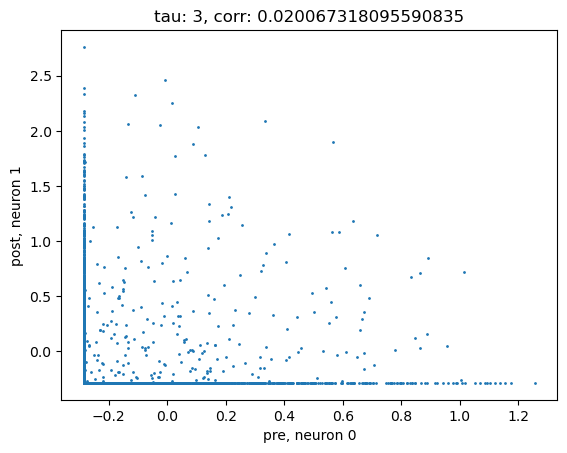

In [9]:
session = all_sessions_acitvity[1]
print('session0 shape: ', session.shape)

tau = 3
pre = 0
post = 1

if tau == 0:
    track1 = session[pre, :]
else:
    track1 = session[pre, :-tau]
track2 = session[post, tau:]

corr = stats.pearsonr(track1, track2)[0]
print('corr: ', corr)

plt.scatter(track1, track2, s=1)
plt.xlabel('pre, neuron ' + str(pre))
plt.ylabel('post, neuron ' + str(post))
plt.title('tau: ' + str(tau) + ', corr: ' + str(corr))
plt.show()

cell_type_order: ['EC', 'IN', 'Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']
['EC', 'IN', 'Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']
{'EC': 292, 'IN': 84, 'Lamp5': 37, 'Pvalb': 16, 'Vip': 25, 'Sncg': 2, 'Sst': 4}


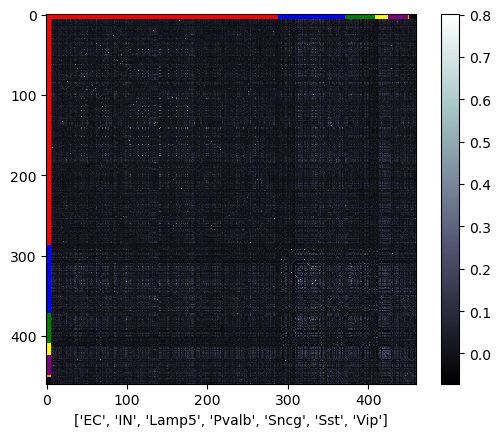

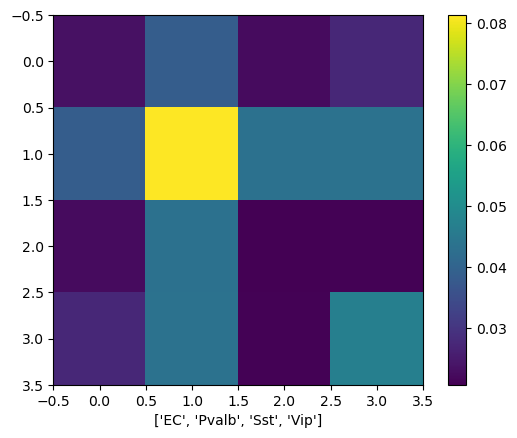

In [33]:
session_id = 1
session= all_sessions_acitvity[session_id]

# correlation_matrix = baselines.get_activity_cross_correlation_matrix(session, tau=1)
correlation_matrix = baselines.get_activity_pearson_correlation_matrix(session)


session_new_cell_type_id, session_cell_type_order = tools.assign_unique_cell_type_ids(all_sessions_original_cell_type[session_id], [num_neurons_per_session[session_id]])
neuron_id_2_cell_type_id = session_new_cell_type_id[0]

print(session_cell_type_order)
print({'EC': 292, 'IN': 84, 'Lamp5': 37, 'Pvalb': 16, 'Vip': 25, 'Sncg': 2, 'Sst': 4})

connectivity_matrix_new = tools.group_connectivity_matrix_by_cell_type(correlation_matrix, neuron_id_2_cell_type_id)

plt.imshow(connectivity_matrix_new, interpolation='nearest', cmap='bone')
plt.colorbar()
plt.plot((0, 0), (0, 291), c='red', linewidth=5)
plt.plot((0, 291), (0, 0), c='red', linewidth=5)

plt.plot((0, 0), (291, 291+84), c='blue', linewidth=5)
plt.plot((291, 291+84), (0, 0), c='blue', linewidth=5)

plt.plot((0, 0), (291+84, 291+84+37), c='green', linewidth=5)
plt.plot((291+84, 291+84+37), (0, 0), c='green', linewidth=5)

plt.plot((0, 0), (291+84+37, 291+84+37+16), c='yellow', linewidth=5)
plt.plot((291+84+37, 291+84+37+16), (0, 0), c='yellow', linewidth=5)

plt.plot((0, 0), (291+84+37+16, 291+84+37+16+25), c='purple', linewidth=5)
plt.plot((291+84+37+16, 291+84+37+16+25), (0, 0), c='purple', linewidth=5)

plt.plot((0, 0), (291+84+37+16+25, 291+84+37+16+25+2), c='orange', linewidth=5)
plt.plot((291+84+37+16+25, 291+84+37+16+25+2), (0, 0), c='orange', linewidth=5)

plt.plot((0, 0), (291+84+37+16+25+2, 291+84+37+16+25+2+4), c='black', linewidth=5)
plt.plot((291+84+37+16+25+2, 291+84+37+16+25+2+4), (0, 0), c='black', linewidth=5)

plt.xlabel(str(session_cell_type_order))
plt.show()


experiment_KK_strength_1 = tools.multisession_NN_to_KK_1(
    [correlation_matrix], 
    None,
    session_cell_type_order,
    session_new_cell_type_id,
)

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_strength_1 = tools.experiment_KK_to_eval_KK(experiment_KK_strength_1, session_cell_type_order, eval_cell_type_order)
plt.imshow(eval_KK_strength_1, interpolation='nearest')
plt.xlabel(str(eval_cell_type_order))
plt.colorbar()
plt.show()

### Cross Correlation

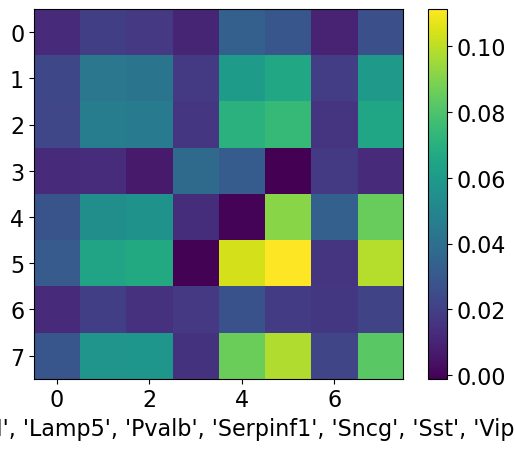

corr:  -0.01690208192132604 , spearman_corr:  SignificanceResult(statistic=-0.07958751947204361, pvalue=0.769529136741207)


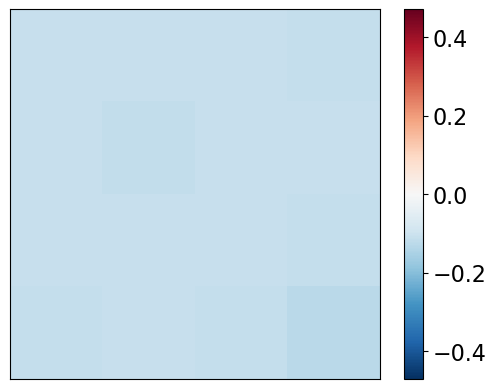

In [8]:
multisession_NN_list = []
for activity in all_sessions_acitvity:
    correlation_matrix = baselines.get_activity_cross_correlation_matrix(activity, tau=1)
    # correlation_matrix = baselines.get_activity_pearson_correlation_matrix(activity)
    multisession_NN_list.append(correlation_matrix)

######### Follow below for evaluation steps ############################
######### 1) First, get multisession_NN_list for connectivity probability
######### 2) (optional) Then, get multisession_binary_NN_list for different shresholds
######### 3) Then, get experiment_KK_strength using 2 ways (optional: for different shresholds)
#########    Also get experiment_KK_prob using 2 ways.    
######### 4) Finally, convert experiment_KK to eval_KK, which is used to compare with ground truth (optional: for different shresholds)
#########    Also convert experiment_KK_prob to eval_KK_prob, which is used to compare with ground truth.  

# 1)
# Perform min-max normalization on each abs(NN) in multisession_NN_list
multisession_NN_list_prob = []
for NN in multisession_NN_list:
    NN = np.abs(NN)
    NN = (NN - np.min(NN)) / (np.max(NN) - np.min(NN))
    multisession_NN_list_prob.append(NN)      

# 3)
# experiment_KK_prob_1 = tools.multisession_NN_to_KK_1(
#     multisession_NN_list_prob, 
#     None,
#     cell_type_order,
#     all_sessions_new_cell_type_id,
# )
experiment_KK_strength_1 = tools.multisession_NN_to_KK_1(
    multisession_NN_list, 
    None,
    cell_type_order,
    all_sessions_new_cell_type_id,
)


# plt.imshow(experiment_KK_prob_1, interpolation='nearest', cmap='bone')
# plt.xlabel(str(cell_type_order))
# plt.colorbar()
# plt.show()
plt.imshow(experiment_KK_strength_1, interpolation='nearest')
plt.xlabel(str(cell_type_order))
plt.colorbar()
plt.show()


# 4)
eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
# eval_KK_prob_1 = tools.experiment_KK_to_eval_KK(experiment_KK_prob_1, cell_type_order, eval_cell_type_order)
# plt.imshow(eval_KK_prob_1, interpolation='nearest', cmap='bone')
# plt.xlabel(str(eval_cell_type_order))
# plt.colorbar()
# plt.show()

eval_KK_strength_1 = tools.experiment_KK_to_eval_KK(experiment_KK_strength_1, cell_type_order, eval_cell_type_order)
corr = np.corrcoef(eval_KK_strength_1.flatten(), GT_strength_connectivity.flatten())[0, 1]
spearman_corr = stats.spearmanr(eval_KK_strength_1.flatten(), GT_strength_connectivity.flatten())
print('corr: ', corr, ', spearman_corr: ', spearman_corr)

transformed_eval_KK_strength_1 = tools.linear_transform(eval_KK_strength_1, GT_strength_connectivity)

plt.imshow(transformed_eval_KK_strength_1, interpolation='nearest', cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

### Mutual Information

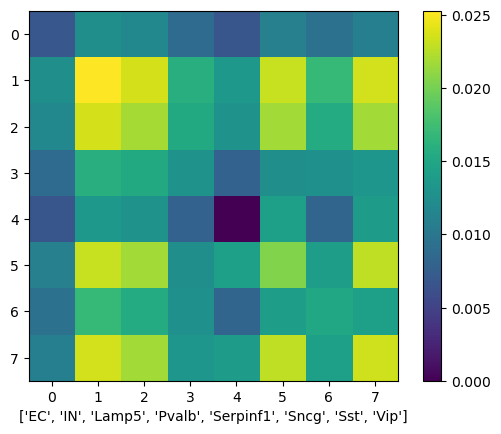

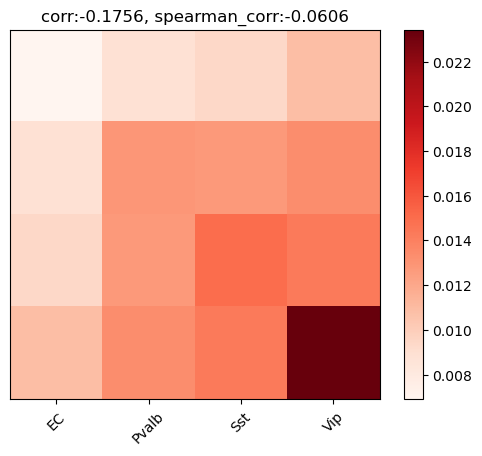

In [9]:
multisession_NN_list = []
for activity in all_sessions_acitvity:
    correlation_matrix = baselines.get_activity_mutual_information(activity, tau=1, bins=50)
    multisession_NN_list.append(correlation_matrix)


experiment_KK_strength_1 = tools.multisession_NN_to_KK_1(
    multisession_NN_list, 
    None,
    cell_type_order,
    all_sessions_new_cell_type_id,
)
plt.imshow(experiment_KK_strength_1, interpolation='nearest')
plt.xlabel(str(cell_type_order))
plt.colorbar()
plt.show()

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_strength_1 = tools.experiment_KK_to_eval_KK(experiment_KK_strength_1, cell_type_order, eval_cell_type_order)

corr = np.corrcoef(eval_KK_strength_1.flatten(), np.abs(GT_strength_connectivity).flatten())[0, 1]
spearman_corr = stats.spearmanr(eval_KK_strength_1.flatten(), np.abs(GT_strength_connectivity).flatten())

plt.imshow(eval_KK_strength_1, interpolation='nearest', cmap='Reds')
plt.xticks(range(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
plt.yticks([])
plt.title('corr:{:.4f}, spearman_corr:{:.4f}'.format(corr, spearman_corr.correlation))
plt.colorbar()
plt.show()

### Transfer Entropy

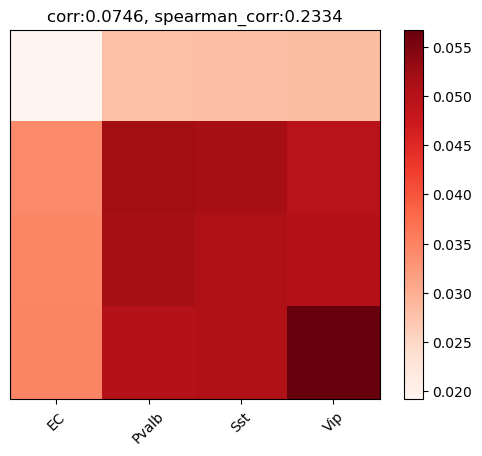

In [10]:
multisession_NN_list = []
for activity in all_sessions_acitvity:
    correlation_matrix = baselines.get_activity_transfer_entropy(activity, history=1, bins=50)
    multisession_NN_list.append(correlation_matrix)


experiment_KK_strength_1 = tools.multisession_NN_to_KK_1(
    multisession_NN_list, 
    None,
    cell_type_order,
    all_sessions_new_cell_type_id,
)

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_strength_1 = tools.experiment_KK_to_eval_KK(experiment_KK_strength_1, cell_type_order, eval_cell_type_order)

corr = np.corrcoef(eval_KK_strength_1.flatten(), np.abs(GT_strength_connectivity).flatten())[0, 1]
spearman_corr = stats.spearmanr(eval_KK_strength_1.flatten(), np.abs(GT_strength_connectivity).flatten())

plt.imshow(eval_KK_strength_1, interpolation='nearest', cmap='Reds')
plt.xticks(range(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
plt.yticks([])
plt.title('corr:{:.4f}, spearman_corr:{:.4f}'.format(corr, spearman_corr.correlation))
plt.colorbar()
plt.show()

### Covariance Matrix

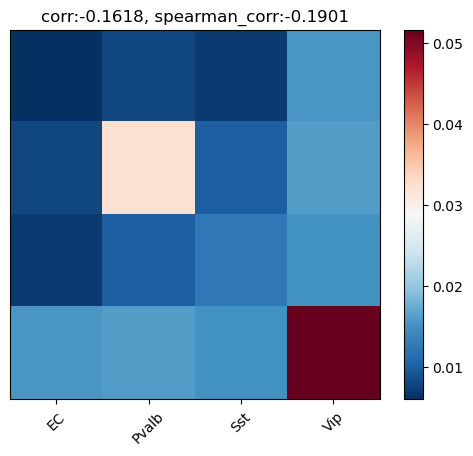

In [20]:
multisession_NN_list = []
for activity in all_sessions_acitvity:
    cov_matrix = np.cov(activity)
    cov_matrix = cov_matrix - np.diag(np.diag(cov_matrix))
    multisession_NN_list.append(cov_matrix)

experiment_KK_strength_1 = tools.multisession_NN_to_KK_1(
    multisession_NN_list, 
    None,
    cell_type_order,
    all_sessions_new_cell_type_id,
)

eval_cell_type_order = ['EC', 'Pvalb', 'Sst', 'Vip']
eval_KK_strength_1 = tools.experiment_KK_to_eval_KK(experiment_KK_strength_1, cell_type_order, eval_cell_type_order)

corr = np.corrcoef(eval_KK_strength_1.flatten(), GT_strength_connectivity.flatten())[0, 1]
spearman_corr = stats.spearmanr(eval_KK_strength_1.flatten(), GT_strength_connectivity.flatten())

plt.imshow(eval_KK_strength_1, interpolation='nearest', cmap='RdBu_r')
plt.xticks(range(len(eval_cell_type_order)), eval_cell_type_order, rotation=45)
plt.yticks([])
plt.title('corr:{:.4f}, spearman_corr:{:.4f}'.format(corr, spearman_corr.correlation))
plt.colorbar()
plt.show()

### Group predicted connectivity by cell types

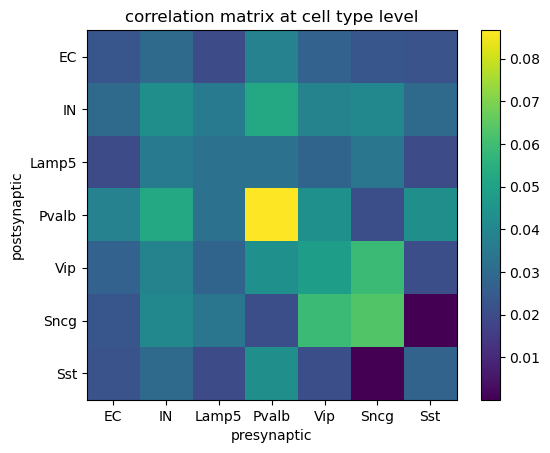

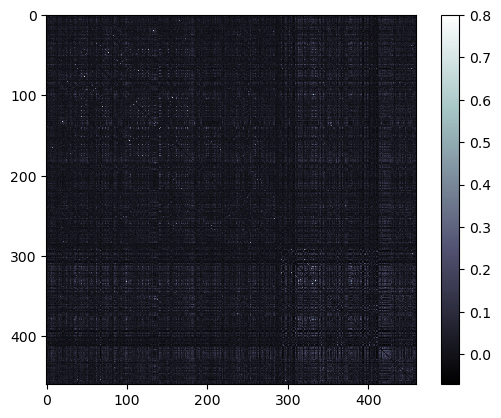

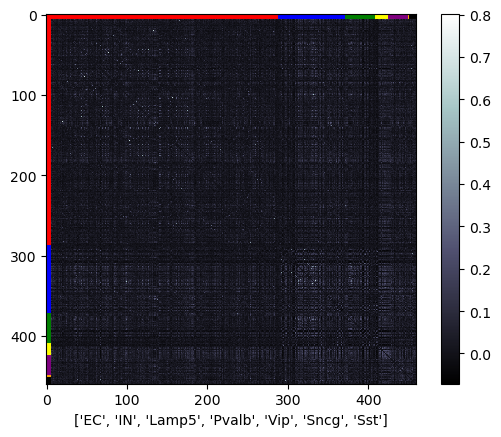

In [33]:
correlation_matrix_new, correlation_matrix_cell_type_level, cell_type2cell_type_index = group_correlation_matrix_by_cell_type(correlation_matrix, neuron_types_result)
cell_type_labels = cell_type2cell_type_index.keys()

plt.imshow(correlation_matrix_cell_type_level, interpolation='nearest')
plt.xticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.yticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.xlabel('presynaptic')
plt.ylabel('postsynaptic')
plt.title('correlation matrix at cell type level')
plt.colorbar()
plt.show()

plt.imshow(correlation_matrix_new, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.show()

# plot
plt.imshow(correlation_matrix_new, cmap='bone', interpolation='nearest')
plt.colorbar()
plt.plot((0, 0), (0, 291), c='red', linewidth=5)
plt.plot((0, 291), (0, 0), c='red', linewidth=5)

plt.plot((0, 0), (291, 291+84), c='blue', linewidth=5)
plt.plot((291, 291+84), (0, 0), c='blue', linewidth=5)

plt.plot((0, 0), (291+84, 291+84+37), c='green', linewidth=5)
plt.plot((291+84, 291+84+37), (0, 0), c='green', linewidth=5)

plt.plot((0, 0), (291+84+37, 291+84+37+16), c='yellow', linewidth=5)
plt.plot((291+84+37, 291+84+37+16), (0, 0), c='yellow', linewidth=5)

plt.plot((0, 0), (291+84+37+16, 291+84+37+16+25), c='purple', linewidth=5)
plt.plot((291+84+37+16, 291+84+37+16+25), (0, 0), c='purple', linewidth=5)

plt.plot((0, 0), (291+84+37+16+25, 291+84+37+16+25+2), c='orange', linewidth=5)
plt.plot((291+84+37+16+25, 291+84+37+16+25+2), (0, 0), c='orange', linewidth=5)

plt.plot((0, 0), (291+84+37+16+25+2, 291+84+37+16+25+2+4), c='black', linewidth=5)
plt.plot((291+84+37+16+25+2, 291+84+37+16+25+2+4), (0, 0), c='black', linewidth=5)

# make x and y axis labels
cell_type_labels = list(cell_type2cell_type_index.keys())

plt.xlabel(str(cell_type_labels))
plt.show()

### Average correlation matrix across different segments
* Segment the whole activity 
* Get correlation matrix for all segments
* Take average of all


In [9]:
print('activity shape: ', activity.shape) 
print('neuron_ttypes shape: ', len(neuron_ttypes))
print('connectivity shape: ', connectivity.shape)

activity shape:  (460, 5249)
neuron_ttypes shape:  460
connectivity shape:  (460, 460)


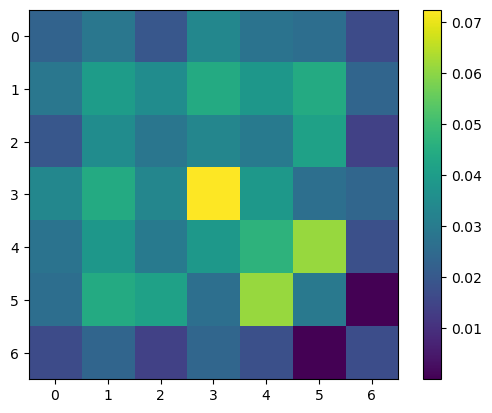

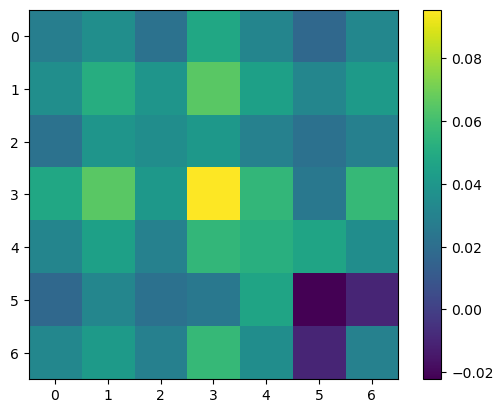

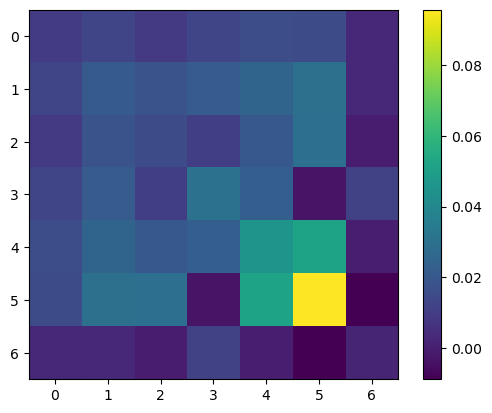

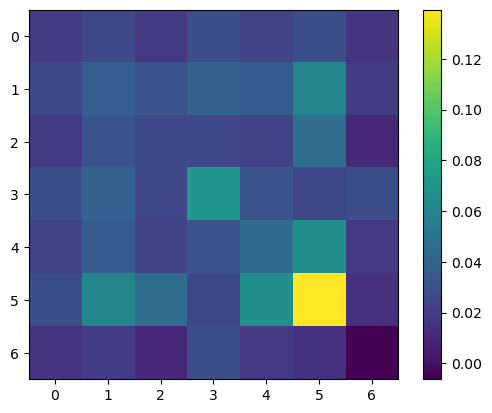

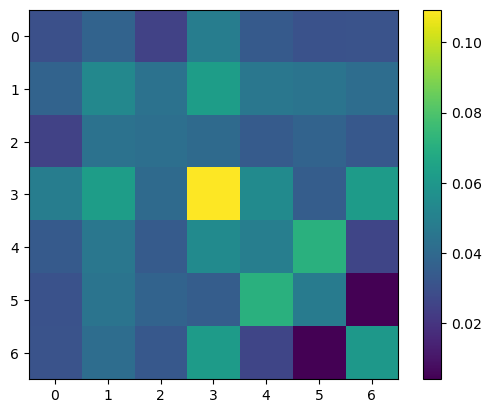

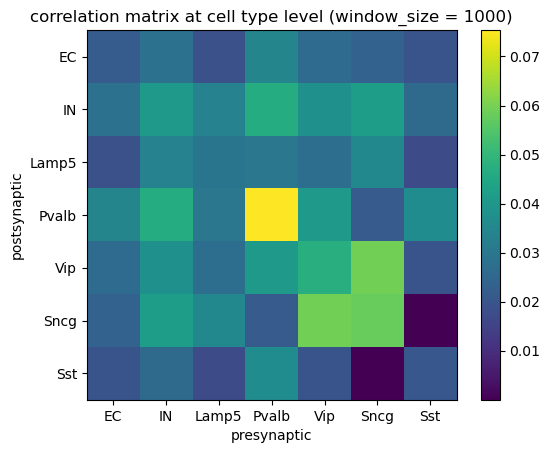

{'EC': 0, 'IN': 1, 'Lamp5': 2, 'Pvalb': 3, 'Vip': 4, 'Sncg': 5, 'Sst': 6}


In [39]:
fragment_size = 1000
num_fragments = activity.shape[1] // fragment_size

sum_cell_type_correlation_matrix = np.zeros((7, 7))

activity_fragmented = np.zeros((num_fragments, activity.shape[0], fragment_size))
for i in range(num_fragments):
    activity_fragmented[i, :, :] = activity[:, i*fragment_size : (i+1)*fragment_size]

    # get correlation matrix
    correlation_matrix = np.corrcoef(activity_fragmented[i, :, :])

    # make the diagonal elements to be 0
    for j in range(correlation_matrix.shape[0]):
        correlation_matrix[j, j] = 0

    # Get new correlation matrix and cell type level correlation matrix
    correlation_matrix_new, correlation_matrix_cell_type_level, cell_type2cell_type_index = group_correlation_matrix_by_cell_type(correlation_matrix, neuron_types_result)

    if i % np.trunc(num_fragments / 3) == 0:
        plt.imshow(correlation_matrix_cell_type_level, interpolation='nearest')
        plt.colorbar()
        plt.show()

    sum_cell_type_correlation_matrix += correlation_matrix_cell_type_level

sum_cell_type_correlation_matrix /= num_fragments

# print(sum_cell_type_correlation_matrix)

plt.imshow(sum_cell_type_correlation_matrix, interpolation='nearest')
# make x and y axis labels
cell_type_labels = cell_type2cell_type_index.keys()
plt.xticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.yticks(np.arange(len(cell_type_labels)), cell_type_labels)
plt.xlabel('presynaptic')
plt.ylabel('postsynaptic')
plt.title('correlation matrix at cell type level (window_size = ' + str(fragment_size) + ')')
plt.colorbar()
plt.show()

print(cell_type2cell_type_index)

### Get correlation between correlation matrix and estimated W from baseline 2

correlation between correlation matrix and estimated W:  0.41108858576289653


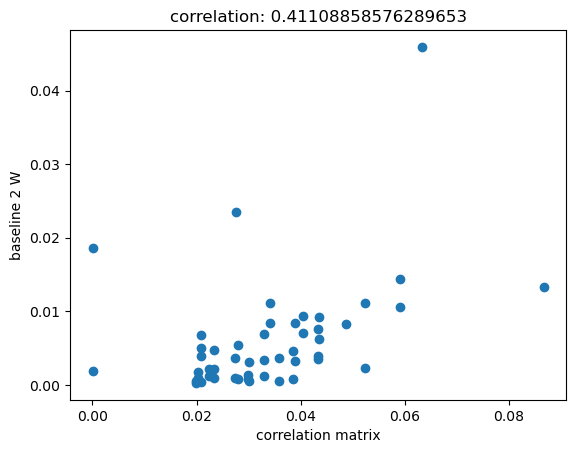

correlation between attention W and estimated W:  0.6855139610120415


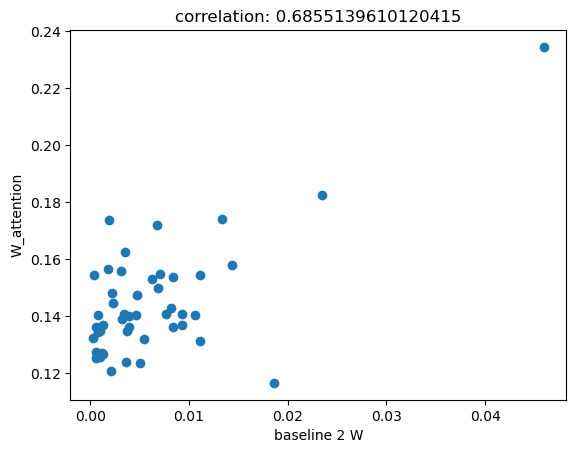

correlation between correlation matrix and W_attention:  0.3999659647621925


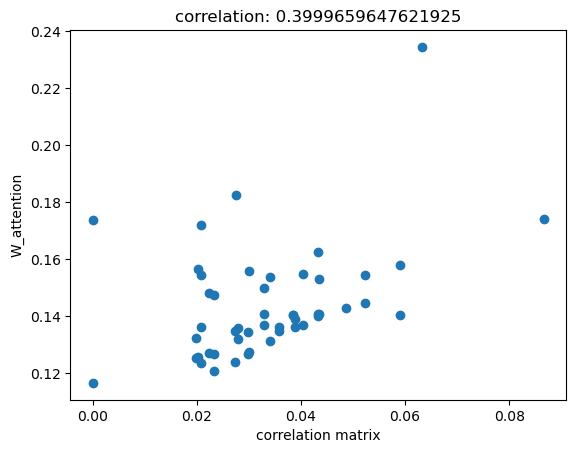

In [38]:
estimated_W_baseline2 = np.load('../../output/10_22_Baseline_2_Mouse_tanh/Baseline_2_mouse_session_460_0.8_200_baseline_2_100_42_1_1_64_258_2_5e-05_none_128_2_5/Estimated_W_cell_type_level.npy')
estimated_W_baseline2 = np.abs(estimated_W_baseline2)

# get correlation
corr = stats.pearsonr(correlation_matrix_cell_type_level.flatten(), estimated_W_baseline2.flatten())[0]
print('correlation between correlation matrix and estimated W: ', corr)

# plot
plt.plot(correlation_matrix_cell_type_level.flatten(), estimated_W_baseline2.flatten(), 'o')
plt.xlabel('correlation matrix')
plt.ylabel('baseline 2 W')
plt.title('correlation: ' + str(corr))
plt.show()

W_attention = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_62_1_1_100_64_0_0.0001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')

# get correlation
corr = stats.pearsonr(estimated_W_baseline2.flatten(), W_attention.flatten())[0]
print('correlation between attention W and estimated W: ', corr)

# plot
plt.plot(estimated_W_baseline2.flatten(), W_attention.flatten(), 'o')
plt.xlabel('baseline 2 W')
plt.ylabel('W_attention')
plt.title('correlation: ' + str(corr))
plt.show()

# get correlation
corr = stats.pearsonr(correlation_matrix_cell_type_level.flatten(), W_attention.flatten())[0]
print('correlation between correlation matrix and W_attention: ', corr)

# plot
plt.plot(correlation_matrix_cell_type_level.flatten(), W_attention.flatten(), 'o')
plt.xlabel('correlation matrix')
plt.ylabel('W_attention')
plt.title('correlation: ' + str(corr))
plt.show()

pearson corr:  0.8620773247405069
spearman corr:  0.6885610731229603
pearson corr abs:  0.484435125314559
prob pearson corr:  0.4449812110979287
prob spearman corr:  0.2783508173361678


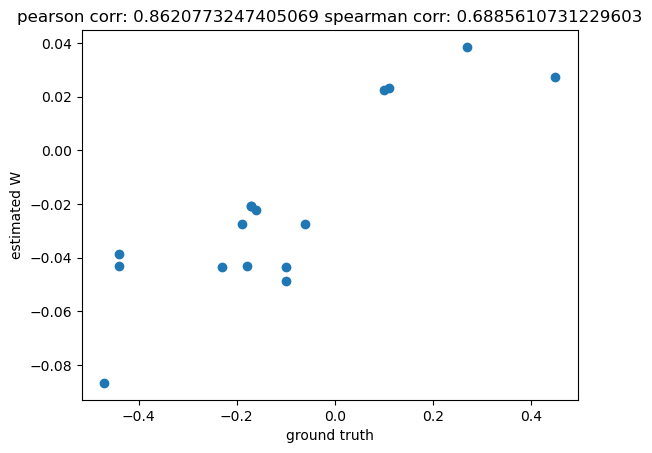

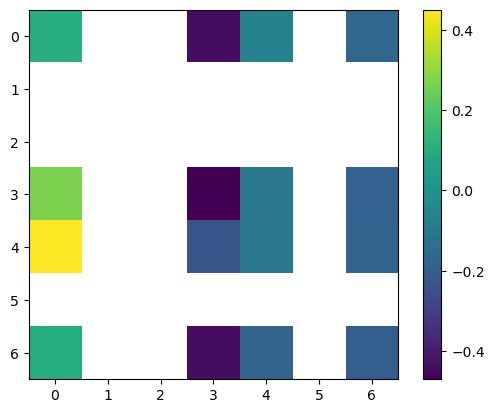

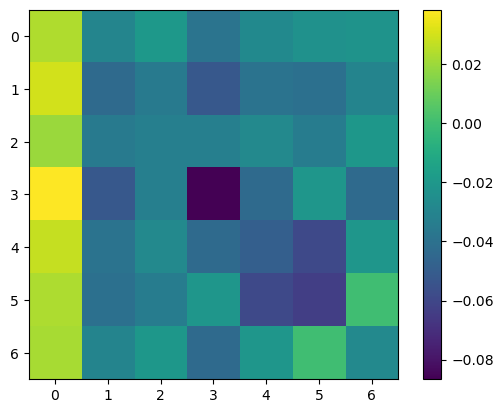

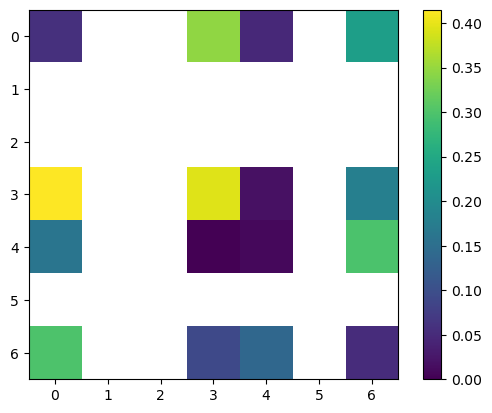

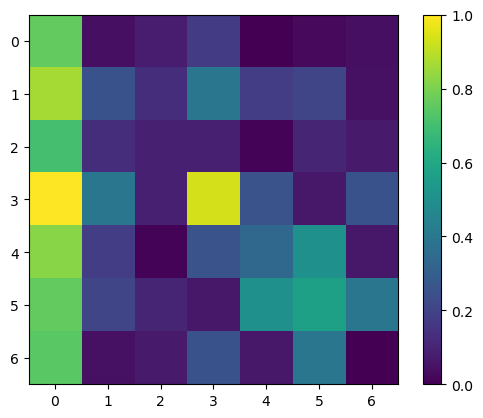

In [43]:
# compute correlation between ground truth and estimated W
# remove nan

# prediction = estimated_W_baseline2
prediction = correlation_matrix_cell_type_level

# make prediction center around 0
# make index 1,2,3,4,5,6 column negative
prediction[:, 1:] = -np.abs(prediction[:, 1:])
# make index 0 column positive
prediction[:, 0] = np.abs(prediction[:, 0])

mask = ~np.isnan(ground_truth_connectivity)

# corr
pearson_corr = stats.pearsonr(ground_truth_connectivity[mask].flatten(), prediction[mask].flatten())[0]
print('pearson corr: ', pearson_corr)

spearman_corr = stats.spearmanr(ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten(), prediction[mask].flatten())[0]
print('spearman corr: ', spearman_corr)

pearson_corr_abs = stats.pearsonr(np.abs(ground_truth_connectivity[~np.isnan(ground_truth_connectivity)]).flatten(), np.abs(prediction[mask].flatten()))[0]
print('pearson corr abs: ', pearson_corr_abs)

# min-max normalization on estimated W
prob_prediction = (prediction - np.mean(prediction)) / np.std(prediction)  #############################
prob_prediction = np.abs(prob_prediction)
prob_prediction = (prob_prediction - np.min(prob_prediction)) / (np.max(prob_prediction) - np.min(prob_prediction))
prob_pearson_corr = stats.pearsonr(ground_truth_prob_connectivity[mask].flatten(), prob_prediction[mask].flatten())[0]
print('prob pearson corr: ', prob_pearson_corr)
prob_spearman_corr = stats.spearmanr(ground_truth_prob_connectivity[mask].flatten(), prob_prediction[mask].flatten())[0]
print('prob spearman corr: ', prob_spearman_corr)

# plot
plt.plot(ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten(), prediction[mask].flatten(), 'o')
plt.xlabel('ground truth')
plt.ylabel('estimated W')
plt.title('pearson corr: ' + str(pearson_corr) + ' spearman corr: ' + str(spearman_corr))
plt.show()

# plot matrix
plt.imshow(ground_truth_connectivity, interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow(prediction, interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow(ground_truth_prob_connectivity, interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow(prob_prediction, interpolation='nearest')
plt.colorbar()
plt.show()

prob pearson corr:  0.24559021947215987
prob spearman corr:  -0.1667908034433846


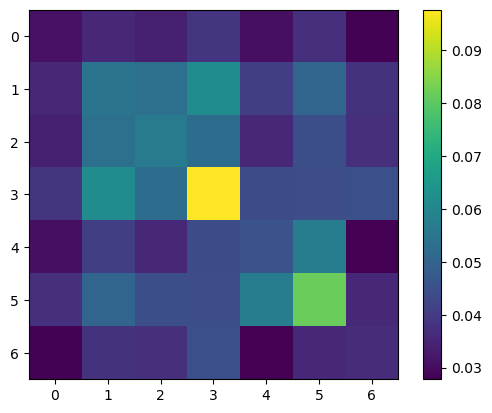

In [44]:
prob_correlation_matrix = (correlation_matrix - np.mean(correlation_matrix)) / np.std(correlation_matrix)
prob_correlation_matrix = np.abs(prob_correlation_matrix)
prob_correlation_matrix = (prob_correlation_matrix - np.min(prob_correlation_matrix)) / (np.max(prob_correlation_matrix) - np.min(prob_correlation_matrix))
prob_correlation_matrix_new, prob_correlation_matrix_cell_type_level, cell_type2cell_type_index = group_correlation_matrix_by_cell_type(prob_correlation_matrix, neuron_types_result)

prob_pearson_corr = stats.pearsonr(ground_truth_prob_connectivity[mask].flatten(), prob_correlation_matrix_cell_type_level[mask].flatten())[0]
print('prob pearson corr: ', prob_pearson_corr)
prob_spearman_corr = stats.spearmanr(ground_truth_prob_connectivity[mask].flatten(), prob_correlation_matrix_cell_type_level[mask].flatten())[0]
print('prob spearman corr: ', prob_spearman_corr)

plt.imshow(prob_correlation_matrix_cell_type_level, interpolation='nearest')
plt.colorbar()
plt.show()

#### Ensemble attention matrix

pearson corr:  0.0017679585033651413
spearman corr:  -0.09999999999999999


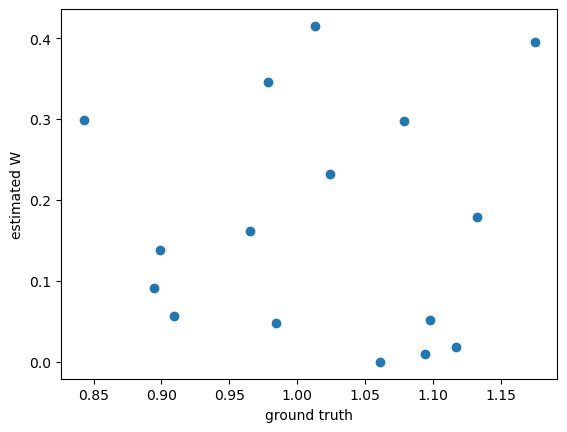

In [106]:
attention_1 = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid_key100/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_12_1_1_100_64_0_0.001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')
attention_2 = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid_key100/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_22_1_1_100_64_0_0.001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')
attention_3 = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid_key100/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_32_1_1_100_64_0_0.001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')
attention_4 = np.load('../../output/10_29_Attention_Mouse_predict_log_poisson_sigmoid_key100/Attention_Autoencoder_mouse_log_460_0.8_20_prediction_1_42_1_1_100_64_0_0.001_lookup_table_128_2_5_poisson/Estimated_W_cell_type_level.npy')
prediction = attention_1 + attention_2 + attention_3 + attention_4


pearson_corr = stats.pearsonr(prediction[~np.isnan(ground_truth_connectivity)].flatten(), ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten())[0]
print('pearson corr: ', pearson_corr)

spearman_corr = stats.spearmanr(prediction[~np.isnan(ground_truth_connectivity)].flatten(), ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten())[0]
print('spearman corr: ', spearman_corr)

# plot
plt.plot(prediction[~np.isnan(ground_truth_connectivity)].flatten(), ground_truth_connectivity[~np.isnan(ground_truth_connectivity)].flatten(), 'o')
plt.xlabel('ground truth')
plt.ylabel('estimated W')
plt.show()

### Baseline LOSS

#### take average of history activity to be the prediction for next activity

In [6]:
window_size = 20 # -------------------------------
split_ratio = 0.8
task_type = "prediction"    # "reconstruction" or "prediction" or "baseline_2" or "mask"
predict_window_size = 1
data_type = "mouse" 

normalization = "session"   # "neuron" or "session" or "none" or "log"
if normalization == "log":
    log_input = True
else:
    log_input = False

loss_function = "guassian"                # "mse" or "poisson" or "guassian"

train_dataloader, val_dataloader, connectivity, neuron_ttypes = data.generate_simulation_data(
    window_size=window_size, 
    split_ratio=split_ratio,
    task_type=task_type,
    predict_window_size=predict_window_size,
    data_type=data_type,
    normalization=normalization
)

# take average of history activity to be the prediction for next activity
avg_loss = []
for val_x, val_y in val_dataloader:
    val_x = val_x.numpy()
    val_y = val_y.numpy().reshape(val_y.shape[0], -1)
    # get the average of history activity
    val_y_pred = np.mean(val_x, axis=2)
    print(val_y_pred.shape)

    # get LOSS
    if loss_function == "mse":
        loss = np.mean((val_y_pred - val_y)**2)
    elif loss_function == "poisson":
        loss_func = torch.nn.PoissonNLLLoss(reduction='mean', log_input=log_input)
        loss = loss_func(torch.from_numpy(val_y_pred), torch.from_numpy(val_y))
    elif loss_function == "guassian":
        loss_func = torch.nn.GaussianNLLLoss(reduction='mean')
        var = torch.ones(val_y_pred.shape)
        loss = loss_func(torch.from_numpy(val_y_pred), torch.from_numpy(val_y), var)
        
    print('loss: ', loss)
    avg_loss.append(loss)

print('average loss: ', np.mean(avg_loss))

torch.Size([460, 5249])
val_data.shape:  torch.Size([1031, 460, 20])
tensor([[-0.2432, -0.2432, -0.2432,  ..., -0.0852, -0.2432, -0.2432],
        [-0.2432, -0.2432, -0.2432,  ..., -0.2432,  1.8518, -0.2432],
        [-0.2432, -0.2432, -0.2432,  ..., -0.2432, -0.2432, -0.2432],
        ...,
        [-0.2432, -0.2432, -0.2432,  ..., -0.2432, -0.2432, -0.2432],
        [-0.2432, -0.2432, -0.2432,  ..., -0.2432, -0.2432, -0.2432],
        [ 0.2952, -0.2432, -0.2432,  ..., -0.2432, -0.0792,  1.5077]])
(32, 460)
loss:  tensor(0.4574)
(32, 460)
loss:  tensor(0.4225)
(32, 460)
loss:  tensor(0.3502)
(32, 460)
loss:  tensor(0.7124)
(32, 460)
loss:  tensor(0.4729)
(32, 460)
loss:  tensor(0.4477)
(32, 460)
loss:  tensor(0.5620)
(32, 460)
loss:  tensor(0.4838)
(32, 460)
loss:  tensor(0.8416)
(32, 460)
loss:  tensor(0.5541)
(32, 460)
loss:  tensor(0.8345)
(32, 460)
loss:  tensor(0.6481)
(32, 460)
loss:  tensor(0.4114)
(32, 460)
loss:  tensor(0.4169)
(32, 460)
loss:  tensor(0.3013)
(32, 460)
loss:  